# Домашняя работа. Feature Engineering. 

В этом соревновании вам нужно предсказать популярность объявления о продаже домов в Нью-Йорке, основываясь на текстовом описании, локации, количестве спален, цене etc.

Вы решаете задачу классификации: нужно предсказать TARGET − low, medium или high. Метрка − точность.

### Загрузим данные

In [133]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [185]:
df = pd.read_csv('train.csv')
df.head()

,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,TARGET
0,57094,1.0,3,0,2016-05-19 18:06:27,A FABULOUS 3BR IN MIDTOWN WEST! PERFECT APAR...,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,['https://photos.renthop.com/2/7039994_07be01b...,4495,W 50 & AVE 10,medium
1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,2016-06-16 02:01:49,Renovated Kitchen and Bathroom!,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,e5808a5e6cc13988fe596704428d38d5,['https://photos.renthop.com/2/7166774_03cf63a...,2570,55 River Drive South,medium
2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,2016-05-04 02:42:50,RARE AND BEST DEAL ON THE MARKET!!!! PERFECT S...,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,d69d4e111612dd12ef864031c1148543,['https://photos.renthop.com/2/6962716_ec7f56f...,1795,22 W 77 Street,low
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,Newly renovated flex 2 apartment offers the ne...,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7002458_93f4010...,3400,100 John Street,low
4,592,1.0,3,fee4d465932160318364d9d48d272879,2016-06-16 06:06:15,LOW FEE apartments do not come around like thi...,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,6fba9b3a8327c607b8b043716efee684,['https://photos.renthop.com/2/7170465_9c3f173...,5695,321 West 16th Street,low


Посмотрим, какие признаки числовые, а какие строковые.

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34546 entries, 0 to 34545
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               34546 non-null  int64  
 1   bathrooms        34546 non-null  float64
 2   bedrooms         34546 non-null  int64  
 3   building_id      34546 non-null  object 
 4   created          34546 non-null  object 
 5   description      33509 non-null  object 
 6   display_address  34458 non-null  object 
 7   features         34546 non-null  object 
 8   latitude         34546 non-null  float64
 9   listing_id       34546 non-null  int64  
 10  longitude        34546 non-null  float64
 11  manager_id       34546 non-null  object 
 12  photos           34546 non-null  object 
 13  price            34546 non-null  int64  
 14  street_address   34542 non-null  object 
 15  TARGET           34546 non-null  object 
dtypes: float64(3), int64(4), object(9)
memory usage: 4.2+ MB


Посмотрим, есть ли Nan в датасете. Для каждой колонки выведем долю Nan в процентах:

In [136]:
round(df.isna().sum() / df.shape[0] * 100, 2)

Id                 0.00
bathrooms          0.00
bedrooms           0.00
building_id        0.00
created            0.00
description        3.00
display_address    0.25
features           0.00
latitude           0.00
listing_id         0.00
longitude          0.00
manager_id         0.00
photos             0.00
price              0.00
street_address     0.01
TARGET             0.00
dtype: float64

Nan есть только в колонках description и display_address, являющиеся строковыми, так что заполнять пропуски я не буду (т.к. эти признаки скорее всего не нужны)

Однако я предположу что отсутствие описания в объявлении негативно влияет на его популярность.

In [137]:
df[df['description'].isna()].TARGET.groupby(df['TARGET']).count()

TARGET
high       33
low       949
medium     55
Name: TARGET, dtype: int64

### Добавление и изменение признаков

Судя по всему, моё предположение верно. (Так как среди объявлений без описания большинство относятся к классу low)
Поэтому добавим в датафрейм колонку с информацией о том, пропущено ли описание или нет.

In [138]:
df['missing'] = np.where(df['description'].isna(), 1, 0)
df.head()


,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,TARGET,missing
0,57094,1.0,3,0,2016-05-19 18:06:27,A FABULOUS 3BR IN MIDTOWN WEST! PERFECT APAR...,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,['https://photos.renthop.com/2/7039994_07be01b...,4495,W 50 & AVE 10,medium,0
1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,2016-06-16 02:01:49,Renovated Kitchen and Bathroom!,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,e5808a5e6cc13988fe596704428d38d5,['https://photos.renthop.com/2/7166774_03cf63a...,2570,55 River Drive South,medium,0
2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,2016-05-04 02:42:50,RARE AND BEST DEAL ON THE MARKET!!!! PERFECT S...,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,d69d4e111612dd12ef864031c1148543,['https://photos.renthop.com/2/6962716_ec7f56f...,1795,22 W 77 Street,low,0
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,Newly renovated flex 2 apartment offers the ne...,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7002458_93f4010...,3400,100 John Street,low,0
4,592,1.0,3,fee4d465932160318364d9d48d272879,2016-06-16 06:06:15,LOW FEE apartments do not come around like thi...,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,6fba9b3a8327c607b8b043716efee684,['https://photos.renthop.com/2/7170465_9c3f173...,5695,321 West 16th Street,low,0


### Выявление категориальных признаков:

In [139]:
def find_cat(data, num_uniq=100):
    for name in data.columns:
        s = ''
        s += name
        if (type(data[name][0]) == str):
            s += ' строка,'
        if (data[name].nunique()<=num_uniq):
            s += ' мало уникальных'
        if (s!=name):
            print (s)
            
find_cat(df)

bathrooms мало уникальных
bedrooms мало уникальных
building_id строка,
created строка,
description строка,
display_address строка,
features строка,
manager_id строка,
photos строка,
street_address строка,
TARGET строка, мало уникальных
missing мало уникальных


Мало уникальных значений в строках bathrooms и bedrooms, однако по смыслу эти признаки не категориальные, а количественные.
Остальные выявленные признаки - строки, но с большим количеством уникальных значений => их стоит убрать.

In [140]:
df = df.drop(columns=['Id', 'building_id', 'description', 'manager_id' ])
df.head()

,bathrooms,bedrooms,created,display_address,features,latitude,listing_id,longitude,photos,price,street_address,TARGET,missing
0,1.0,3,2016-05-19 18:06:27,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,['https://photos.renthop.com/2/7039994_07be01b...,4495,W 50 & AVE 10,medium,0
1,1.0,1,2016-06-16 02:01:49,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,['https://photos.renthop.com/2/7166774_03cf63a...,2570,55 River Drive South,medium,0
2,1.0,0,2016-05-04 02:42:50,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,['https://photos.renthop.com/2/6962716_ec7f56f...,1795,22 W 77 Street,low,0
3,1.0,2,2016-05-12 05:57:56,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,['https://photos.renthop.com/2/7002458_93f4010...,3400,100 John Street,low,0
4,1.0,3,2016-06-16 06:06:15,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,['https://photos.renthop.com/2/7170465_9c3f173...,5695,321 West 16th Street,low,0


Преобразуем признак photos, заменив ссылки (с которыми непонятно, как работать), на их количество

In [141]:
df['photos'] = df['photos'].apply(lambda x: len(x.split()))
df.head()

,bathrooms,bedrooms,created,display_address,features,latitude,listing_id,longitude,photos,price,street_address,TARGET,missing
0,1.0,3,2016-05-19 18:06:27,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,3,4495,W 50 & AVE 10,medium,0
1,1.0,1,2016-06-16 02:01:49,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,13,2570,55 River Drive South,medium,0
2,1.0,0,2016-05-04 02:42:50,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,6,1795,22 W 77 Street,low,0
3,1.0,2,2016-05-12 05:57:56,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,4,3400,100 John Street,low,0
4,1.0,3,2016-06-16 06:06:15,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,3,5695,321 West 16th Street,low,0


Поработаем с признаком created, представляющим собой дату и время:

In [142]:
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
df.head()

,bathrooms,bedrooms,created,display_address,features,latitude,listing_id,longitude,photos,price,street_address,TARGET,missing
0,1.0,3,2016-05-19 18:06:27,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,3,4495,W 50 & AVE 10,medium,0
1,1.0,1,2016-06-16 02:01:49,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,13,2570,55 River Drive South,medium,0
2,1.0,0,2016-05-04 02:42:50,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,6,1795,22 W 77 Street,low,0
3,1.0,2,2016-05-12 05:57:56,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,4,3400,100 John Street,low,0
4,1.0,3,2016-06-16 06:06:15,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,3,5695,321 West 16th Street,low,0


In [143]:
df['created'].dt.year.head().nunique()

1

Год создания объявления у всех одинаковый => год нам не нужен.
Создадим признаки: месяц, день недели

In [144]:
df['month'] = df['created'].dt.month
df['weekday'] = df['created'].dt.weekday
df['hour'] = df['created'].dt.hour
df.head()


,bathrooms,bedrooms,created,display_address,features,latitude,listing_id,longitude,photos,price,street_address,TARGET,missing,month,weekday,hour
0,1.0,3,2016-05-19 18:06:27,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,3,4495,W 50 & AVE 10,medium,0,5,3,18
1,1.0,1,2016-06-16 02:01:49,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,13,2570,55 River Drive South,medium,0,6,3,2
2,1.0,0,2016-05-04 02:42:50,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,6,1795,22 W 77 Street,low,0,5,2,2
3,1.0,2,2016-05-12 05:57:56,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,4,3400,100 John Street,low,0,5,3,5
4,1.0,3,2016-06-16 06:06:15,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,3,5695,321 West 16th Street,low,0,6,3,6


In [145]:
df[['weekday', 'TARGET']].groupby(df['TARGET']).describe()

weekday                                             
          count      mean       std  min  25%  50%  75%  max
TARGET                                                      
high     2687.0  2.913658  1.788934  0.0  1.0  3.0  4.0  6.0
low     23999.0  2.925997  1.792612  0.0  1.0  3.0  4.0  6.0
medium   7860.0  2.893130  1.778132  0.0  1.0  3.0  4.0  6.0

In [146]:
df[['month', 'TARGET']].groupby(df['TARGET']).describe()

month                                             
          count      mean       std  min  25%  50%  75%  max
TARGET                                                      
high     2687.0  5.004094  0.819293  4.0  4.0  5.0  6.0  6.0
low     23999.0  5.024959  0.824505  4.0  4.0  5.0  6.0  6.0
medium   7860.0  5.009669  0.821463  4.0  4.0  5.0  6.0  6.0

In [147]:
df[['hour', 'TARGET']].groupby(df['TARGET']).describe()

hour                                              
          count      mean       std  min  25%  50%  75%   max
TARGET                                                       
high     2687.0  6.438407  5.081083  0.0  3.0  5.0  7.0  23.0
low     23999.0  4.329014  3.884479  0.0  2.0  3.0  5.0  23.0
medium   7860.0  5.548728  4.499542  0.0  3.0  5.0  6.0  23.0

Мы вытащили из признака created всё что можно, теперь можно его удалить.

In [148]:
df = df.drop(columns='created')
df.head()

,bathrooms,bedrooms,display_address,features,latitude,listing_id,longitude,photos,price,street_address,TARGET,missing,month,weekday,hour
0,1.0,3,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,3,4495,W 50 & AVE 10,medium,0,5,3,18
1,1.0,1,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,13,2570,55 River Drive South,medium,0,6,3,2
2,1.0,0,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,6,1795,22 W 77 Street,low,0,5,2,2
3,1.0,2,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,4,3400,100 John Street,low,0,5,3,5
4,1.0,3,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,3,5695,321 West 16th Street,low,0,6,3,6


Оставим в признаке street_address только название улицы (уберём дом):


In [149]:
def get_street(s):
    s = str(s).split()
    return ' '.join(s[1:])
df['street_address'] = df['street_address'].apply(get_street)
df.head()

,bathrooms,bedrooms,display_address,features,latitude,listing_id,longitude,photos,price,street_address,TARGET,missing,month,weekday,hour
0,1.0,3,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,3,4495,50 & AVE 10,medium,0,5,3,18
1,1.0,1,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,13,2570,River Drive South,medium,0,6,3,2
2,1.0,0,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,6,1795,W 77 Street,low,0,5,2,2
3,1.0,2,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,4,3400,John Street,low,0,5,3,5
4,1.0,3,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,3,5695,West 16th Street,low,0,6,3,6


Посмотрим количество уникальных значений в колонках, содержащих улицы:

In [150]:
df['street_address'].nunique()

5096

In [151]:
df['display_address'].nunique()

6998

5000 улиц - слишком много для того, чтобы считать этот признак категориальным. Поэтому также уберём эти признаки:

In [152]:
df = df.drop(columns=['display_address', 'street_address', 'listing_id'])
df.head()

,bathrooms,bedrooms,features,latitude,longitude,photos,price,TARGET,missing,month,weekday,hour
0,1.0,3,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,-73.9918,3,4495,medium,0,5,3,18
1,1.0,1,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,-74.0322,13,2570,medium,0,6,3,2
2,1.0,0,"['Elevator', 'Hardwood Floors']",40.7798,-73.9751,6,1795,low,0,5,2,2
3,1.0,2,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,-74.0065,4,3400,low,0,5,3,5
4,1.0,3,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,-74.0025,3,5695,low,0,6,3,6


In [153]:
features_unique = []
for i in df['features'].tolist():
    for j in i.split("'"):
        if j.lower() not in features_unique and len(j) < 50 and (',' not in j) and ('[' not in j) and (']' not in j):
            features_unique.append(j.lower())
features_unique
    

['laundry in unit',
 'no fee',
 'elevator',
 'dogs allowed',
 'cats allowed',
 'hardwood floors',
 'swimming pool',
 'doorman',
 'fitness center',
 'dishwasher',
 'laundry in building',
 'pre-war',
 'roof deck',
 'outdoor space',
 'common outdoor space',
 'private outdoor space',
 'parking space',
 'high speed internet available',
 'complimentary continental breakfast',
 'valet laundry',
 'dry cleaning service',
 'electronic rent payment',
 'outdoor basketball court',
 'wifi in resident lounge',
 'free brealfast',
 'new construction',
 'publicoutdoor',
 'garage',
 'prewar',
 'live in super',
 'lowrise',
 'laundry',
 'high ceilings',
 'simplex',
 'hardwood',
 'pool',
 'storage',
 'loft',
 'lounge room',
 'on-site laundry',
 'balcony',
 'garden/patio',
 'terrace',
 'dining room',
 'furnished',
 'reduced fee',
 'high speed internet',
 'roof-deck',
 'laundry room',
 'exclusive',
 'eat in kitchen',
 'high ceiling',
 'wheelchair access',
 'light',
 'renovated',
 'green building',
 'multi-lev

In [154]:
len(features_unique)

910

In [155]:
def f(string, feature):
    string = [i.lower() for i in (string.split("'"))]
    if feature in string:
        return 1
    else:
        return 0

for feature in features_unique:
    df[feature] = df['features'].apply(f, feature=feature)

df.head()

,bathrooms,bedrooms,features,latitude,longitude,photos,price,TARGET,missing,month,...,equal king-size bedrooms,brand new ss kitchen,polished hardwood floors,sparkling marble bathroom,mins from train,no fee hardwood floors,brand new ss appliances,700 sf,new,total reno. heart of west village
0,1.0,3,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,-73.9918,3,4495,medium,0,5,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,-74.0322,13,2570,medium,0,6,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0,"['Elevator', 'Hardwood Floors']",40.7798,-73.9751,6,1795,low,0,5,...,0,0,0,0,0,0,0,0,0,0
3,1.0,2,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,-74.0065,4,3400,low,0,5,...,0,0,0,0,0,0,0,0,0,0
4,1.0,3,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,-74.0025,3,5695,low,0,6,...,0,0,0,0,0,0,0,0,0,0


In [156]:
df = df.drop(columns='features')

### Baseline

In [157]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']

In [158]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=179)

In [159]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(max_iter=1000)
log.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [160]:
y_pred = log.predict(X_test)
y_pred

array(['low', 'low', 'low', ..., 'medium', 'low', 'low'], dtype=object)

In [161]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.37811599297913584

### Улучшение модели путём отбора признаков

Так как из колонки features мы извлекли очень мгого новых признаков, скорее всего какие-то из них неважны => стоит отобрать лучшие. Сделаем это с помощью ANOVA:
    

In [171]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
score_list = []
n_features = []
for i in range(10, 151, 10):
    x_data_kbest = SelectKBest(f_classif, k=i).fit_transform(X, y)
    score_list.append(cross_val_score(LogisticRegression(), x_data_kbest, y, scoring='balanced_accuracy').mean())
    n_features.append(i)


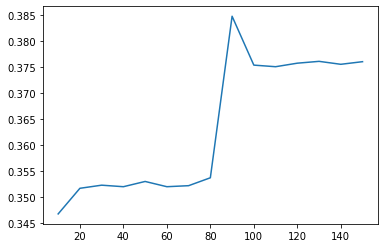

In [172]:
import matplotlib.pyplot as plt
plt.plot(n_features, score_list)
plt.show()

Лучший результат - при 90 признаках. Посмотрим, какой будет результат, если данные нормализовать

In [173]:
normalized_X = (X-X.mean())/X.std()
x_data_kbest = SelectKBest(f_classif, k=90).fit_transform(normalized_X, y)
cross_val_score(LogisticRegression(), x_data_kbest, y, scoring='balanced_accuracy').mean()

0.3810135718995556

In [174]:
normalized_X = (X-X.min())/(X.max()-X.min())
x_data_kbest = SelectKBest(f_classif, k=90).fit_transform(normalized_X, y)
cross_val_score(LogisticRegression(), x_data_kbest, y, scoring='balanced_accuracy').mean()

0.3531923105500695

mean normalization показала лучший результат чем min-max.

Так как классы несбалансированы, необходимо добавить соответствующий параметр в модель:

In [186]:
df.groupby('TARGET').count()

,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
TARGET,,,,,,,,,,,,,,,
high,2687,2687,2687,2687,2687,2654,2674,2687,2687,2687,2687,2687,2687,2687,2686
low,23999,23999,23999,23999,23999,23050,23943,23999,23999,23999,23999,23999,23999,23999,23996
medium,7860,7860,7860,7860,7860,7805,7841,7860,7860,7860,7860,7860,7860,7860,7860


In [178]:
normalized_X = (X-X.mean())/X.std()
x_data_kbest = SelectKBest(f_classif, k=90).fit_transform(normalized_X, y)
cross_val_score(LogisticRegression(class_weight='balanced'),
                x_data_kbest, y, scoring='balanced_accuracy').mean()

0.5404634743967643

Данные действия намного улучшили результат 

Перебор параметра max_iter:

In [190]:
scores = []
iters = []
for i in range(100, 1001, 100):
    iters.append(i)
    scores.append(cross_val_score(LogisticRegression(class_weight='balanced', max_iter = i),
                    x_data_kbest, y, scoring='balanced_accuracy').mean())

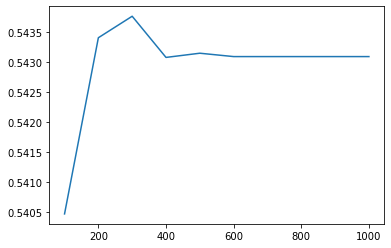

In [191]:
plt.plot(iters, scores)
plt.show()

Лучший результат - max_iter = 300

Перебор коэффициента регуляризации:

In [196]:
scores = []
coefs = [0.3, 0.7, 1, 1.5, 2, 2.5, 3, 4, 5]
for i in coefs:
    scores.append(cross_val_score(LogisticRegression(class_weight='balanced', max_iter = 300, C=i),
                    x_data_kbest, y, scoring='balanced_accuracy').mean())

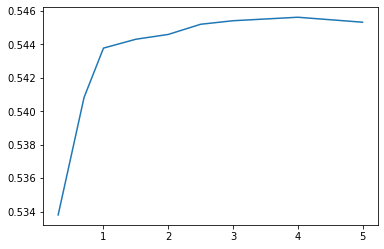

In [197]:
plt.plot(coefs, scores)
plt.show()

Лучший результат при коэффициенте = 4

# Итоговый accuracy = 0.546

### Применение KNN 

In [183]:
from sklearn.neighbors import KNeighborsClassifier
n_neighbors = []
scores = []
for i in range(5, 31, 5):
    scores.append(cross_val_score(KNeighborsClassifier(n_neighbors=i), 
                    x_data_kbest, y, scoring='balanced_accuracy').mean())
    n_neighbors.append(i)
    

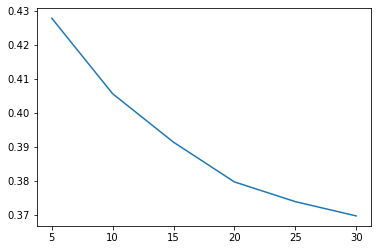

In [184]:
plt.plot(n_neighbors, scores)
plt.show()

при любых значениях перебираемого параметра результат хуже чем на логистической регрессии.

### Работа с test.csv

In [238]:
test_df = pd.read_csv('test.csv')
test_df.head()

,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,low,2.0,3,87c4e08083ac83618dd9fdbf849331fe,2016-06-21 03:21:59,Rent listed is net effective after one month f...,E 77 St.,"['Pre-War', 'Laundry in Unit', 'Dishwasher', '...",40.7716,7189305,-73.9544,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7189305_f47ed5c...,4675,339 E 77 St.
1,low,1.0,2,850c3d4412aebb3335273ed95f3e4bd4,2016-06-11 03:47:06,A FABULOUS 2BR IN THE UPPER EAST SIDE! PERFECT...,E 112 Street,[],40.7944,7140670,-73.9401,3e9f0fa34d67e5d61aae56776ecb8cee,['https://photos.renthop.com/2/7140670_6c5824f...,2100,252 E 112 Street
2,low,1.0,2,84ddf917a091828ab9baedc0c926470e,2016-04-17 02:45:19,This is a great true 2 bedroom in a prime Midt...,Ninth Avenue,"['Dogs Allowed', 'Cats Allowed']",40.7650,6886239,-73.9882,10b1ae0a38d50b7ba0cee612d14af9eb,['https://photos.renthop.com/2/6886239_533bbee...,2800,783 Ninth Avenue
3,high,2.0,3,315a2f868a195b076e5be73411110da2,2016-05-07 11:44:35,Brand new custom renovation in beautiful three...,East 12th street,"['Laundry In Unit', 'No Fee', 'Washer/Dryer in...",40.7288,6981146,-73.9808,e9920062e07ee893c10e38d0259665b0,['https://photos.renthop.com/2/6981146_f4a7400...,5500,186 Avenue B
4,medium,1.0,3,9b525bacc8d294728c35f27c04e22f46,2016-06-24 07:33:26,"Welcome Home! Located on a Prime UWS Block, Ba...",West 86th&Columbus,"['Private Outdoor Space', 'Elevator', 'Laundry...",40.7864,7210864,-73.9713,6d389fbe372d4d30b17733caa9370f95,['https://photos.renthop.com/2/7210864_e8528f4...,3995,47 West 86th street


In [219]:
df = test_df.copy()
df['missing'] = np.where(df['description'].isna(), 1, 0)
df = df.drop(columns=['Id', 'building_id', 'description', 'manager_id' ])
df['photos'] = df['photos'].apply(lambda x: len(x.split()))
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
df['month'] = df['created'].dt.month
df['weekday'] = df['created'].dt.weekday
df['hour'] = df['created'].dt.hour
df = df.drop(columns='created')
df = df.drop(columns=['display_address', 'street_address', 'listing_id'])

for feature in features_unique:
    df[feature] = df['features'].apply(f, feature=feature)
    
df = df.drop(columns='features')
df.head()

,bathrooms,bedrooms,latitude,longitude,photos,price,missing,month,weekday,hour,...,equal king-size bedrooms,brand new ss kitchen,polished hardwood floors,sparkling marble bathroom,mins from train,no fee hardwood floors,brand new ss appliances,700 sf,new,total reno. heart of west village
0,2.0,3,40.7716,-73.9544,8,4675,0,6,1,3,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,40.7944,-73.9401,4,2100,0,6,5,3,...,0,0,0,0,0,0,0,0,0,0
2,1.0,2,40.7650,-73.9882,7,2800,0,4,6,2,...,0,0,0,0,0,0,0,0,0,0
3,2.0,3,40.7288,-73.9808,7,5500,0,5,5,11,...,0,0,0,0,0,0,0,0,0,0
4,1.0,3,40.7864,-73.9713,10,3995,0,6,4,7,...,0,0,0,0,0,0,0,0,0,0


Посмотрим, какие признаки отбирает ANOVA

In [220]:
normalized_X = (X-X.mean())/X.std()
select = SelectKBest(f_classif, k=90)
x_data_kbest = select.fit_transform(normalized_X, y)

filter = select.get_support()

(normalized_X.columns)[filter]

Index(['bathrooms', 'bedrooms', 'price', 'missing', 'hour', 'laundry in unit',
       'no fee', 'elevator', 'dogs allowed', 'cats allowed', 'hardwood floors',
       'doorman', 'fitness center', 'dishwasher', 'laundry in building',
       'pre-war', 'roof deck', 'outdoor space', 'common outdoor space',
       'private outdoor space', 'parking space', 'new construction',
       'publicoutdoor', 'garage', 'prewar', 'lowrise', 'laundry',
       'high ceilings', 'simplex', 'hardwood', 'pool', 'storage', 'loft',
       'balcony', 'garden/patio', 'terrace', 'dining room', 'furnished',
       'reduced fee', 'high speed internet', 'roof-deck', 'laundry room',
       'exclusive', 'light', 'renovated', 'short term allowed',
       'residents lounge', 'washer in unit', 'dryer in unit', 'fireplace',
       'patio', 'bike room', 'gym/fitness', 'stainless steel appliances',
       'walk in closet(s)', 'wifi access', 'on-site garage', 'newly renovated',
       'childrens playroom', 'actual apt. photo

In [225]:
del_features = []
for i in df.columns.to_list():
    if i not in (normalized_X.columns)[filter].to_list():
        del_features.append(i)
        
df = df.drop(columns=del_features)
df.head()

,bathrooms,bedrooms,price,missing,hour,laundry in unit,no fee,elevator,dogs allowed,cats allowed,...,bike & stroller storage,pet grooming room,stunning roof deck with breathtaking views,roof grilling area,rentable,party room,near transportation,heat hot water included,huge room,renovated kitchen
0,2.0,3,4675,0,3,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2100,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,2,2800,0,2,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,2.0,3,5500,0,11,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,3,3995,0,7,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [230]:
normalized_df = (df-df.mean())/df.std()
normalized_df = normalized_df.fillna(0)
normalized_df.head()


,bathrooms,bedrooms,price,missing,hour,laundry in unit,no fee,elevator,dogs allowed,cats allowed,...,bike & stroller storage,pet grooming room,stunning roof deck with breathtaking views,roof grilling area,rentable,party room,near transportation,heat hot water included,huge room,renovated kitchen
0,1.530093,1.310878,0.338606,-0.168543,-0.418579,2.092328,1.307335,-1.048841,-0.898264,1.045439,...,-0.008218,-0.008218,-0.008218,-0.008218,-0.008218,-0.016438,-0.008218,0.0,0.0,-0.008218
1,-0.417848,0.410820,-0.549587,-0.168543,-0.418579,-0.477904,-0.764863,-1.048841,-0.898264,-0.956471,...,-0.008218,-0.008218,-0.008218,-0.008218,-0.008218,-0.016438,-0.008218,0.0,0.0,-0.008218
2,-0.417848,0.410820,-0.308136,-0.168543,-0.657642,-0.477904,-0.764863,-1.048841,1.113184,1.045439,...,-0.008218,-0.008218,-0.008218,-0.008218,-0.008218,-0.016438,-0.008218,0.0,0.0,-0.008218
3,1.530093,1.310878,0.623172,-0.168543,1.493928,2.092328,1.307335,-1.048841,-0.898264,-0.956471,...,-0.008218,-0.008218,-0.008218,-0.008218,-0.008218,-0.016438,-0.008218,0.0,0.0,-0.008218
4,-0.417848,1.310878,0.104054,-0.168543,0.537674,-0.477904,-0.764863,0.953369,-0.898264,-0.956471,...,-0.008218,-0.008218,-0.008218,-0.008218,-0.008218,-0.016438,-0.008218,0.0,0.0,-0.008218


In [241]:
model = LogisticRegression(class_weight='balanced', max_iter = 300, C=4)
model.fit(x_data_kbest, y)
y_pred = model.predict(normalized_df)
y_pred

array(['low', 'high', 'high', ..., 'high', 'high', 'high'], dtype=object)

In [244]:
id_list = pd.read_csv('sample_submission.csv')

submit = pd.DataFrame.from_dict({'Id':id_list.Id.values, 'TARGET': y_pred})
submit.to_csv("submit.csv", index=False)
submit.head()

,Id,TARGET
0,19477,low
1,29937,high
2,109148,high
3,65728,low
4,33623,low
